In [1]:
library(cowplot)
library(magrittr)
library(ggrepel)
library(igraph)
library(tidyverse)
library(tidygraph)
library(ggnetwork)
suppressWarnings(suppressMessages(library(network)))
suppressWarnings(suppressMessages(library(sna)))

theme_set(theme_cowplot())
results <- '../results/'
vegas <- read_tsv(paste0(results,'preprocessing/scored_genes.vegas.txt'), 
                  col_types = 'iciddddddcd') %>%
    rename(p = `Top-0.1-pvalue`) %>%
    select(Gene, p)
ppi <- read_tsv(paste0(results,'preprocessing/hint.ht_complex.hgnc.pseudo.tab2'), col_types = 'cccccccccicc') %>%
    select(`Official Symbol Interactor A`, `Official Symbol Interactor B`) %>%
    graph_from_data_frame(directed = FALSE) %>%
    as_tbl_graph %>%
    mutate(betweenness = centrality_betweenness(),
           degree = centrality_degree()) %>%
    left_join(vegas, by = c('name' = 'Gene'))


********************************************************
Note: As of version 1.0.0, cowplot does not change the
  default ggplot2 theme anymore. To recover the previous
  behavior, execute:
  theme_set(theme_cowplot())
********************************************************

Loading required package: ggplot2

Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  2.1.3     ✔ purrr   0.3.2
✔ tidyr   0.8.3     ✔ dplyr   0.8.3
✔ readr   1.3.1     ✔ stringr 1.4.0
✔ tibble  2.1.3     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::as_data_frame() masks tibble::as_data_frame(), igraph::as_data_frame()
✖ purrr::compose()       masks igraph::compose()
✖ tidyr::crossing()      masks igraph::crossing()
✖ tidyr::extract()       mas

# Subnetworks

## LEAN

In [2]:
lean_p <- read_tsv(paste0(results,'lean/scored_genes.lean.txt'), col_types = 'cdddddddd')
lean <- lean_p$Gene[lean_p$PLEAN < 0.05]
g_lean <- activate(ppi, nodes) %>%
    filter(name %in% lean)

Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Removed 2 rows containing missing values (geom_bar).”

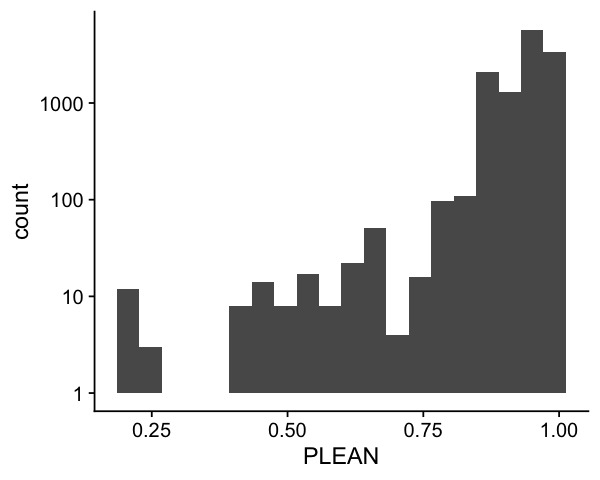

In [3]:
options(repr.plot.width=5, repr.plot.height=4)
ggplot(lean_p, aes(PLEAN)) +
    geom_histogram(bins = 20) +
    scale_y_log10()

## Sigmod

In [4]:
sigmod <- read_tsv(paste0(results,'sigmod/selected_genes.sigmod.txt'), col_types = 'c')$gene
g_sigmod <- activate(ppi, nodes) %>%
    filter(name %in% sigmod) %>%
    mutate(sigmod = TRUE)
class(g_sigmod) <- c('igraph','tbl_graph')

Warning message in if (class(x) == "igraph") {:
“the condition has length > 1 and only the first element will be used”Warning message in fortify.network(intergraph::asNetwork(model), ...):
“duplicated edges detected”

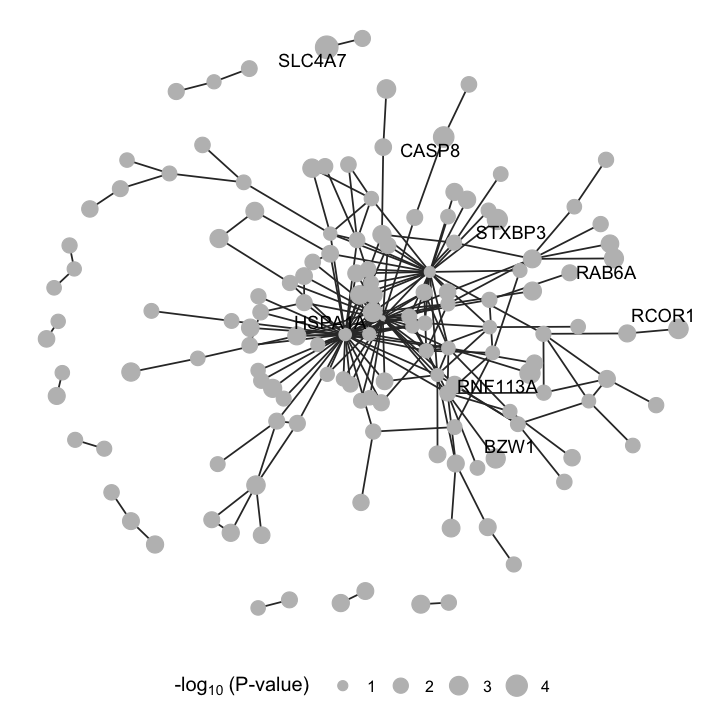

In [5]:
options(repr.plot.width=6, repr.plot.height=6)
g_sigmod %>%
    ggnetwork %>%
    mutate(vertex.names = as.character(vertex.names)) %>%
    ggplot(aes(x = x, y = y, xend = xend, yend = yend)) +
        geom_edges(color = 'gray20') +
        geom_nodes(aes(size = -log10(p)), color = 'gray') +
        geom_nodetext_repel(aes(label = ifelse(p < 0.001, vertex.names, ''))) +
        theme_blank() +
        theme(legend.position = 'bottom') +
        labs(size = bquote('-log' [10] ~'(P-value)'))

## dmGWAS

In [6]:
dmgwas <- read_tsv(paste0(results,'dmgwas/selected_genes.dmgwas.txt'), col_types = 'c')$gene

In [7]:
g_dmgwas <- activate(ppi, nodes) %>%
    filter(name %in% dmgwas) %>%
    mutate(dmgwas = TRUE)
class(g_dmgwas) <- c('igraph','tbl_graph')

Warning message in if (class(x) == "igraph") {:
“the condition has length > 1 and only the first element will be used”Warning message in fortify.network(intergraph::asNetwork(model), ...):
“duplicated edges detected”Warning message:
“Column `vertex.names`/`Gene` joining factor and character vector, coercing into character vector”ERROR while rich displaying an object: Error in FUN(X[[i]], ...): object 'p' not found

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% na

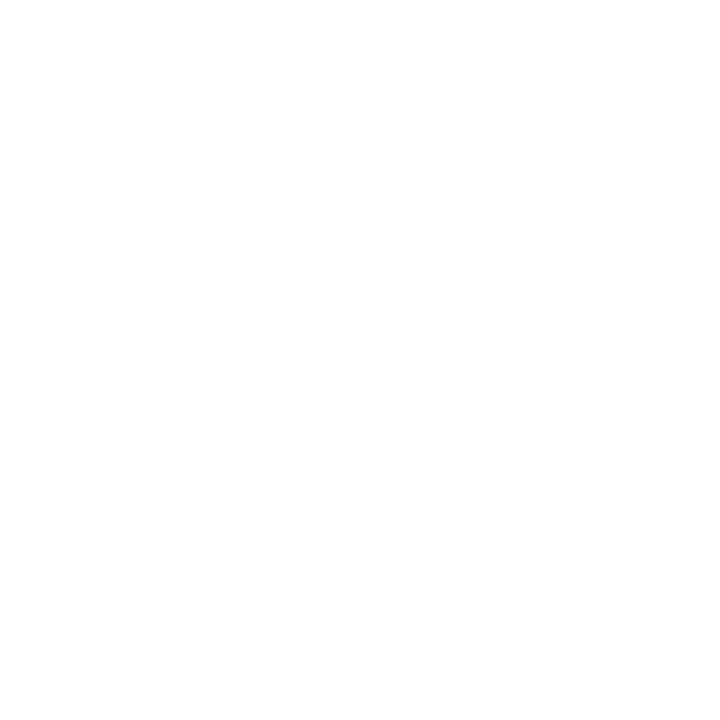

In [8]:
options(repr.plot.width=6, repr.plot.height=6)
g_dmgwas %>%
    ggnetwork %>%
    left_join(vegas, by = c('vertex.names' = 'Gene')) %>%
    mutate(vertex.names = as.character(vertex.names)) %>%
    ggplot(aes(x = x, y = y, xend = xend, yend = yend)) +
        geom_edges(color = 'gray20') +
        geom_nodes(aes(size = -log10(p)), color = 'gray') +
        geom_nodetext_repel(aes(label = ifelse(p < 0.001, vertex.names, ''))) +
        theme_blank() +
        theme(legend.position = 'bottom') +
        labs(size = bquote('-log' [10] ~'(P-value)'))

## Heinz

In [9]:
heinz <- read_tsv(paste0(results,'heinz/selected_genes.heinz.txt'), col_types = 'c')$gene

In [10]:
g_heinz <- activate(ppi, nodes) %>%
    filter(name %in% heinz) %>%
    mutate(heinz = TRUE)
class(g_heinz) <- c('igraph','tbl_graph')

## SConES

In [11]:
snp2gene <- read_tsv(paste0(results,'preprocessing/snp2hgnc.tsv'), col_types = 'cc')

scones_gs <- read_tsv(paste0(results,'scones/cones_gs.tsv'), col_types = 'cildccdli') %>%
    filter(selected) %>%
    inner_join(snp2gene, by = "snp") %>%
    select(gene) %>%
    .$gene %>%
    unique
scones_gm <- read_tsv(paste0(results,'scones/cones_gm.tsv'), col_types = 'cildccdli') %>%
    filter(selected) %>%
    inner_join(snp2gene, by = "snp") %>%
    select(gene) %>%
    .$gene %>%
    unique
scones_gm
scones_gi <- read_tsv(paste0(results,'scones/cones_gi.tsv'), col_types = 'cildccdli') %>%
    filter(selected) %>%
    inner_join(snp2gene, by = "snp") %>%
    select(gene) %>%
    .$gene %>%
    unique

g_scones_gs <- activate(ppi, nodes) %>%
    filter(name %in% scones_gs) %>%
    mutate(scones_gs = TRUE)
class(g_scones_gs) <- c('igraph','tbl_graph')

g_scones_gm <- activate(ppi, nodes) %>%
    filter(name %in% scones_gm) %>%
    mutate(scones_gm = TRUE)
class(g_scones_gm) <- c('igraph','tbl_graph')

g_scones_gi <- activate(ppi, nodes) %>%
    filter(name %in% scones_gi) %>%
    mutate(scones_gi = TRUE)
class(g_scones_gi) <- c('igraph','tbl_graph')

[1] "NEK10"     "MICOS10P3" "RNU6-342P" "SLC4A7"    "RPS20P15"  "RNU1-96P"

# Heterogeneity study

Warning message:
“Removed 1 rows containing missing values (geom_text).”

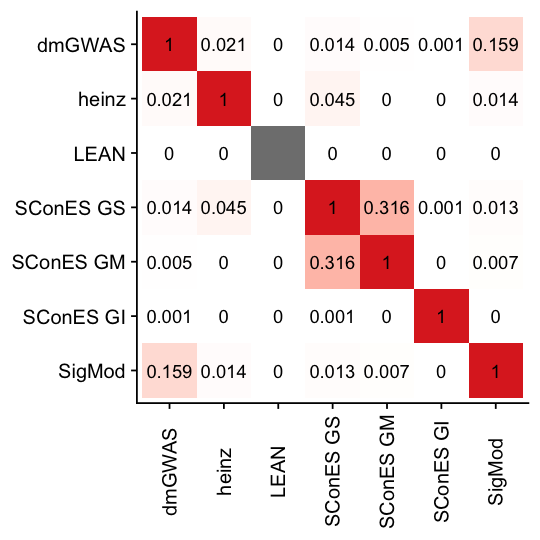

In [12]:
methods <- c('dmGWAS','heinz','LEAN','SConES GS','SConES GM','SConES GI','SigMod')
bms <- list(dmgwas, heinz, lean, scones_gs, scones_gm, scones_gi, sigmod)

options(repr.plot.width=4.5, repr.plot.height=4.5)
lapply(bms, function(x) 
       lapply(bms, function(x,y) 
           length(intersect(x,y))/length(union(x,y)), x) ) %>%
    do.call(cbind, .) %>%
    as.data.frame %>%
    set_colnames(methods) %>%
    mutate(method1 = factor(methods, levels = methods)) %>%
    gather(method2, jaccard, -method1) %>%
    mutate(method2 = factor(method2, levels = rev(methods)),
           jaccard = round(as.numeric(jaccard), digits = 3)) %>%
    ggplot(aes(x = method1, y = method2, fill = jaccard, label = jaccard)) +
        geom_tile() +
        geom_text() +
        scale_fill_gradient(low = 'white', high = '#de2d26') +
        theme(legend.position = 'none',
              axis.title.x = element_blank(),
              axis.title.y = element_blank(),
              axis.text.x = element_text(angle = 90, vjust = 0.5))

In [13]:
method_summary <- function(graph) {
    
    tibble(`# nodes` = length(V(graph)),
           `# edges` = length(E(graph)),
           `Median betweenness` = mean(as.tibble(graph) %>% .$betweenness, na.rm = T) %>% format(digits = 2),
           `Median gene P-value` = median(as.tibble(graph) %>% .$p, na.rm = T) %>% format(digits = 2))
    
}

In [14]:
methods <- c('dmGWAS','heinz','LEAN','SConES GS','SConES GM','SConES GI','SigMod')

bind_rows(mutate(method_summary(ppi), Method = 'HINT'),
          mutate(method_summary(g_dmgwas), Method = 'dmGWAS'),
          mutate(method_summary(g_heinz), Method = 'heinz'),
          mutate(method_summary(g_lean), Method = 'LEAN'),
          mutate(method_summary(g_scones_gs), Method = 'SConES GS'),
          mutate(method_summary(g_scones_gm), Method = 'SConES GM'),
          mutate(method_summary(g_scones_gi), Method = 'SConES GI'),
          mutate(method_summary(g_sigmod), Method = 'SigMod')) %>%
    select(Method, everything())

Warning message:
“`as.tibble()` is deprecated, use `as_tibble()` (but mind the new semantics).
This warning is displayed once per session.”

Method,# nodes,# edges,Median betweenness,Median gene P-value
<chr>,<int>,<int>,<chr>,<chr>
HINT,13619,142541,16706,0.46
dmGWAS,194,450,49115,0.19
heinz,4,3,113633,0.0012
LEAN,0,0,NaN,NA
SConES GS,5,0,9805,2.7e-05
SConES GM,1,0,8722,2.7e-05
SConES GI,143,2,69,0.11
SigMod,142,249,92603,0.0083


# Consensus subnetwork

In [15]:
# from DisGeNET
known_brca_genes <- read_tsv(paste0(results,'consensus/C0346153_disease_gda_summary.tsv'), 
                             col_types = 'ccciccciddddcddddd')$Gene
g_known <- activate(ppi, nodes) %>%
    filter(name %in% known_brca_genes) %>%
    mutate(known = TRUE)
class(g_known) <- c('igraph','tbl_graph')

In [24]:
options(repr.plot.width=25, repr.plot.height=15)
consensus <- graph_join(g_sigmod, g_dmgwas, by = c('name','betweenness','degree','p')) %>%
    graph_join(g_heinz, by = c('name','betweenness','degree','p')) %>%
    graph_join(g_scones_gs, by = c('name','betweenness','degree','p')) %>%
    graph_join(g_known, by = c('name','betweenness','degree','p')) %>%
    to_undirected %>%
    mutate(num_methods = rowSums(cbind(dmgwas, sigmod, heinz, scones_gs, known), na.rm = TRUE),
           known = ifelse(is.na(known), FALSE, known)) %>%
    filter(num_methods > 1) %>%
    mutate() 

as.tibble(consensus) %>%
    rename(name = gene) %>%
    write_tsv(paste0(results,'consensus/consensus.tsv'))

consensus_gg <- consensus %>%
    ggnetwork

highlight <- consensus_gg$num_methods == 3 | 
             consensus_gg$p < 0.001 | 
             consensus_gg$degree > 100 |
             consensus_gg$known

ggplot() +
    geom_edges(data = consensus_gg, aes(x = x, y = y, xend = xend, yend = yend), 
               size = 5, color = 'grey80') +
    geom_nodes(data = filter(consensus_gg, !highlight), 
               aes(x = x, y = y), size = 10, fill = 'gray20', color = 'white', shape = 22) +
    geom_nodelabel(data = filter(consensus_gg, highlight), 
                   aes(x = x, y = y, label = vertex.names, fill = known), 
                   size = 15, color = 'white') +
    theme_blank() +
    labs(size = '# methods') +
    scale_size_manual(values = c('2' = 6, '3' = 10)) +
    scale_fill_manual(values = c('TRUE' = '#ff96a7', 'FALSE' = '#252525')) +
    theme(text = element_text(size = 40), legend.position = 'none')

ERROR: Error in rename(., name = gene): object 'gene' not found


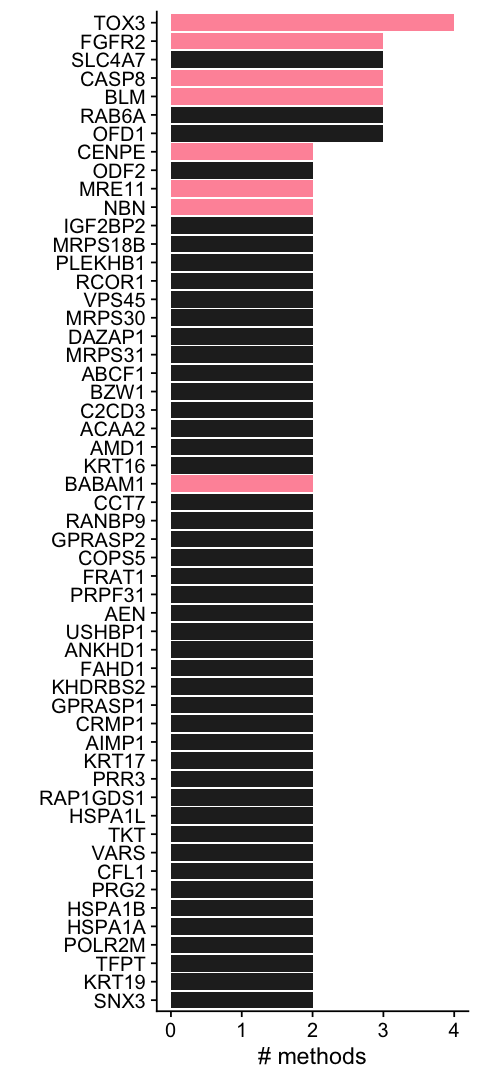

In [17]:
options(repr.plot.width=4, repr.plot.height=9)
as.tibble(consensus) %>%
    arrange(num_methods) %>%
    mutate(name = factor(name, levels = name)) %>%
    ggplot(aes(x = name, y = num_methods, fill = known)) +
        geom_bar(stat = 'identity') +
        coord_flip() +
        scale_fill_manual(values = c('TRUE' = '#ff96a7', 'FALSE' = '#252525')) +
        labs(x = '', y = '# methods') +
        theme(legend.position = 'none')

In [18]:
known_consensus <- sum(as.tibble(consensus) %>% .$known)
known_not_consensus <- length(known_brca_genes) - known_consensus
unknown_consensus <- nrow(as.tibble(consensus)) - known_consensus
unknown_not_consensus <- nrow(vegas) - unknown_consensus - known_not_consensus - known_consensus

fisher.test(matrix(c(known_consensus,known_not_consensus,
                     unknown_consensus, unknown_not_consensus),
                   nrow = 2))


	Fisher's Exact Test for Count Data

data:  
p-value = 1.63e-10
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 15.62793 85.65928
sample estimates:
odds ratio 
  38.97865 


# Topology study

In [19]:
topology <- ppi %>%
    mutate(in_consensus = name %in% unique(consensus_gg[['vertex.names']]),
           what = ifelse(in_consensus, 'Consensus', 'Rest'),
           what = ifelse(name %in% known_brca_genes, 'Known', what),
           what = ifelse(in_consensus & name %in% known_brca_genes, 'Consensus + known', what)) %>%
    as.tibble

Warning message:
“Removed 409 rows containing non-finite values (stat_boxplot).”

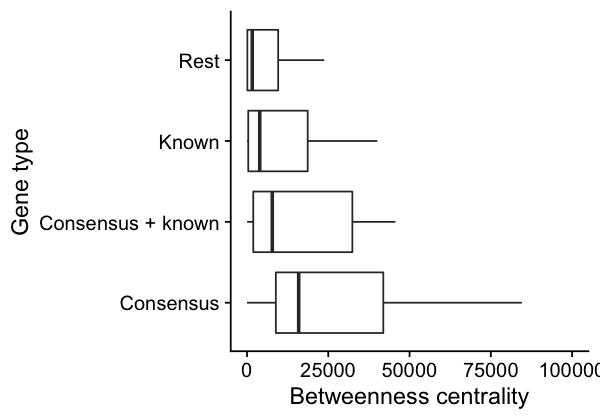

In [20]:
options(repr.plot.width=5, repr.plot.height=3.5)
topology %>%
    ggplot(aes(x = what, y = betweenness)) +
        geom_boxplot(outlier.colour = NA) +
        scale_y_continuous(limits = c(0, 1e+5)) +
        labs(x = 'Gene type', y = 'Betweenness centrality') +
        coord_flip()

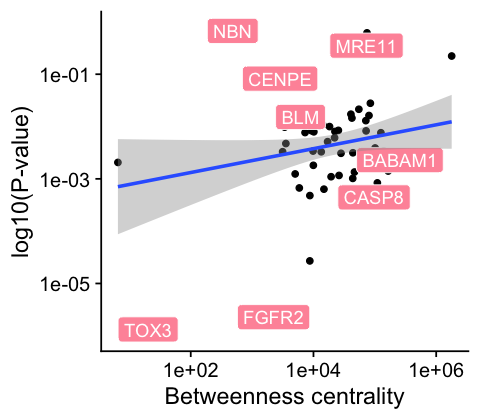

In [21]:
options(repr.plot.width=4, repr.plot.height=3.5)
ggplot() +
    geom_point(
        data = filter(topology, what == 'Consensus'),
        aes(y = p, x = betweenness)) +
    geom_label_repel(
        data = filter(topology, what == 'Consensus + known'),
        aes(y = p, x = betweenness, label = name),
        fill = '#ff96a7', color = 'white') +
    geom_smooth(data = filter(topology, what == 'Consensus'), 
                aes(y = p, x = betweenness), method = "glm") +
    labs(x = 'Betweenness centrality', y = 'log10(P-value)') +
    scale_x_log10() +
    scale_y_log10()

# Gene set enrichment analysis

In [22]:
suppressPackageStartupMessages(library(clusterProfiler))
suppressPackageStartupMessages(library(org.Hs.eg.db))

In [23]:
go_enrich <- enrichGO(gene    = unique(consensus_gg[['vertex.names']]),
                      OrgDb   = org.Hs.eg.db,
                      keyType = 'SYMBOL') %>%
    as_tibble
go_enrich

ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0004003,ATP-dependent DNA helicase activity,3/54,31/16969,0.0001285592,0.01215399,0.009779071,BLM/NBN/MRE11,3
GO:0051082,unfolded protein binding,4/54,83/16969,0.0001397010,0.01215399,0.009779071,HSPA1A/HSPA1B/HSPA1L/CCT7,4
GO:0016887,ATPase activity,6/54,280/16969,0.0002541928,0.01393348,0.011210845,HSPA1A/HSPA1B/BLM/ABCF1/NBN/MRE11,6
GO:0003678,DNA helicase activity,3/54,42/16969,0.0003203099,0.01393348,0.011210845,BLM/NBN/MRE11,3
GO:0008026,ATP-dependent helicase activity,3/54,52/16969,0.0006029254,0.01574938,0.012671918,BLM/NBN/MRE11,3
GO:0070035,purine NTP-dependent helicase activity,3/54,52/16969,0.0006029254,0.01574938,0.012671918,BLM/NBN/MRE11,3
GO:0042623,"ATPase activity, coupled",5/54,218/16969,0.0006335959,0.01574938,0.012671918,HSPA1A/HSPA1B/BLM/NBN/MRE11,5
GO:0044183,protein binding involved in protein folding,2/54,14/16969,0.0008826277,0.01919715,0.015445985,HSPA1A/HSPA1B,2
GO:0008094,DNA-dependent ATPase activity,3/54,72/16969,0.0015557036,0.02911559,0.023426337,BLM/NBN/MRE11,3
